# Fuzzy Control

In [1]:
import sys
import numpy as np
import matplotlib.pyplot as plt

sys.path.append("../")

from softpy.fuzzy.fuzzyset import *
from softpy.fuzzy.operations import *
from softpy.fuzzy.fuzzy_control import *
from softpy.fuzzy.knowledge_base import *
from softpy.fuzzy.fuzzy_partition import *
from softpy.fuzzy.fuzzy_rule import *

## Mamdani Controller

In [2]:
def outside_temperature(start_temp, days=1):
    temps = []
    temp = start_temp
    for d in range(days):
        for time in range(6):
            temps.append(temp)
            temp -= 0.9

        for time in range(6,9):
            temps.append(temp)
            temp += 0.67

        for time in range(9,15):
            temps.append(temp)
            temp += 1.67

        for time in range(15, 18):
            temps.append(temp)
            temp += 0.7

        for time in range(18,24):
            temps.append(temp)
            temp -= 1.6


    return temps

In [3]:
def inhouse_temperature(in_t_prev, out_t_curr, control):
    return (out_t_curr + in_t_prev)/2 + control

In [4]:
out_t = outside_temperature(15, 10)
in_t = [out_t[0]]
for i in range(1, len(out_t)):
    in_t.append(inhouse_temperature(in_t[i-1], out_t[i], 0))

(0.0, 36.0)

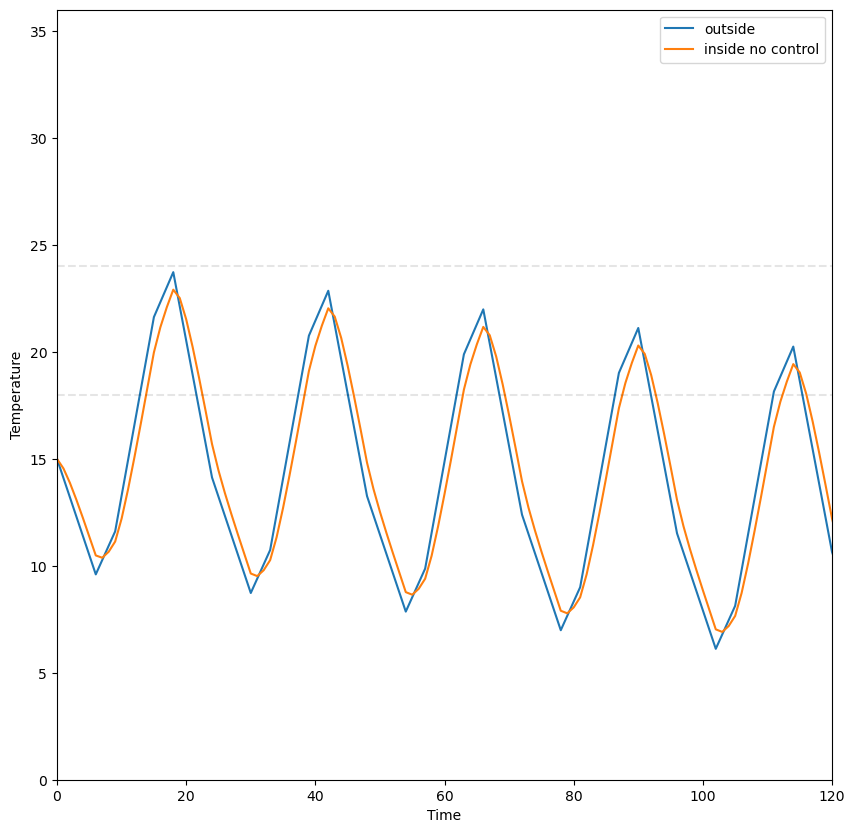

In [5]:
plt.figure(figsize=(10,10))

plt.plot(out_t, label="outside")
plt.plot(in_t, label="inside no control")

plt.axhline(y=18, color='k', linestyle='--', alpha=0.1)
plt.axhline(y=24, color='k', linestyle='--', alpha=0.1)


plt.legend()

plt.xlabel("Time")
plt.ylabel("Temperature")
plt.xlim(0,24*5)
plt.ylim(0,36)

In [6]:
bound_temperature = (0, 40)
bound_controller = (-10, 10)
temperature_partition = FuzzyPartition('temperature', {
    'low': LinearZFuzzySet(15, 18, bound=bound_temperature),
    'medium': TrapezoidalFuzzySet(14, 16, 26, 28, bound=bound_temperature),
    'high': LinearSFuzzySet(24, 27, bound=bound_temperature),
})

controller_partition = FuzzyPartition('controller', {
    'low': ZShapedFuzzySet(-2,-1, bound=bound_controller),
    'low-medium': GaussianFuzzySet(-1, 1, bound=bound_controller),
    'nochange': GaussianFuzzySet(0, 1, bound=bound_controller),
    'high-medium': GaussianFuzzySet(1, 1, bound=bound_controller),
    'high': SShapedFuzzySet(1,2, bound=bound_controller),
})

(-0.01, 1.01)

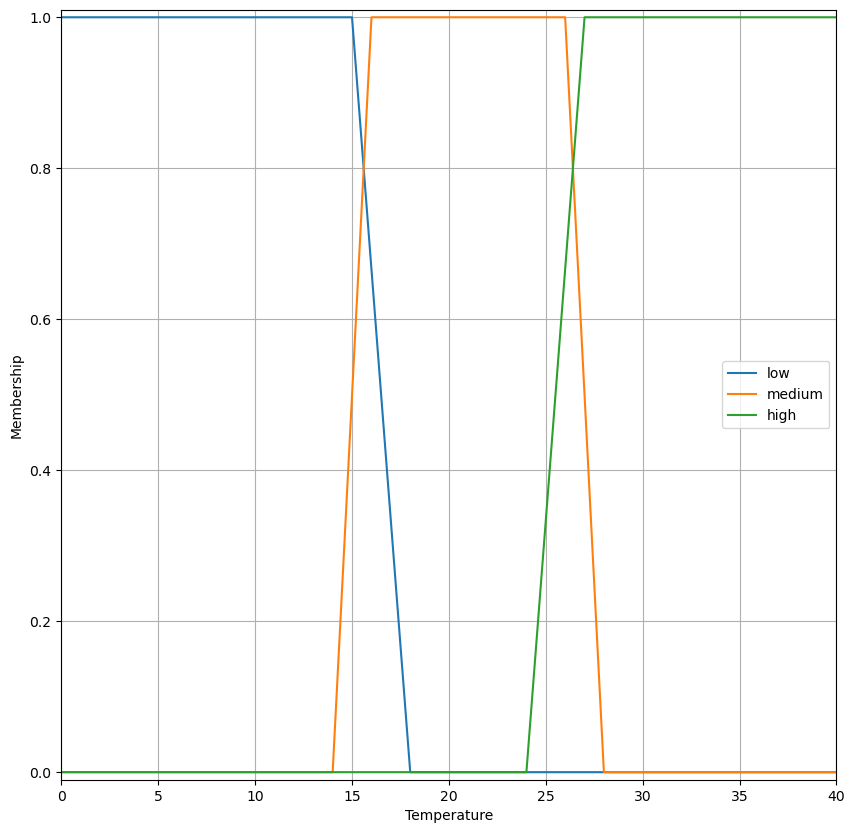

In [7]:
xs = np.linspace(0, 40, int(41 / 1e-2))

plt.figure(figsize=(10,10))

for name in temperature_partition.get_fuzzy_set_names():
    l = [temperature_partition[name](v) for v in xs]
    plt.plot(xs, l, label=name)
    
plt.legend()

plt.xlabel("Temperature")
plt.ylabel("Membership")
plt.grid()
plt.xlim(bound_temperature)
plt.ylim(-0.01,1.01)

(-0.01, 1.01)

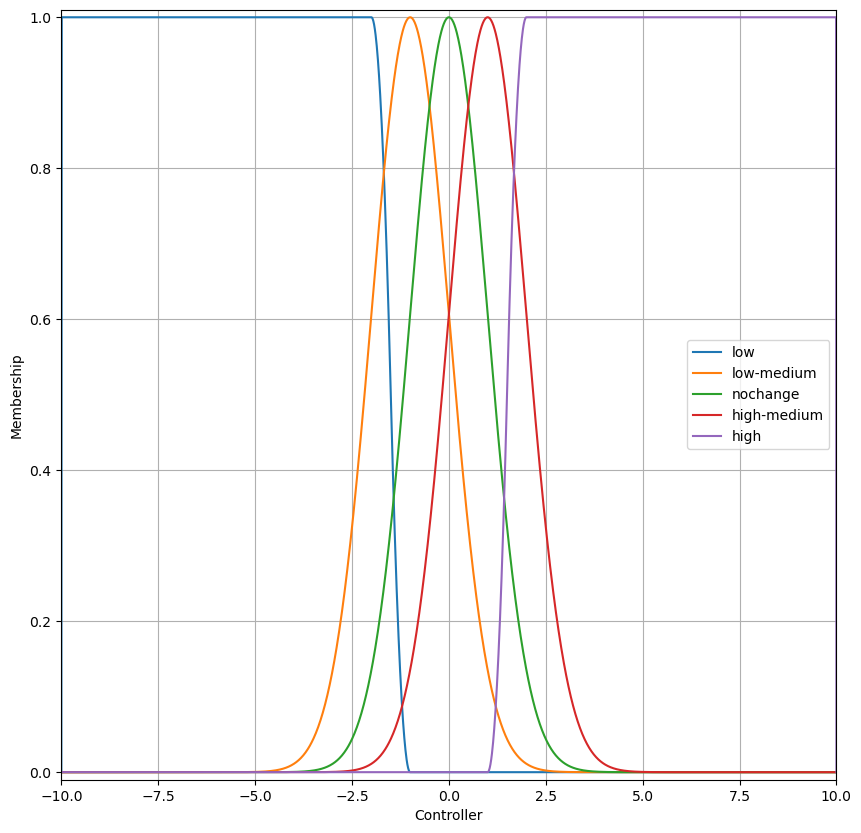

In [8]:
xs = np.linspace(-40, 40, int(81 / 1e-2))

plt.figure(figsize=(10,10))

for name in controller_partition.get_fuzzy_set_names():
    l = [controller_partition[name](v) for v in xs]
    plt.plot(xs, l, label=name)
    
plt.legend()

plt.xlabel("Controller")
plt.ylabel("Membership")
plt.grid()
plt.xlim(bound_controller)
plt.ylim(-0.01,1.01)

In [9]:
rules = [
    MamdaniRule({temperature_partition.name: [temperature_partition['low']]},
                controller_partition.name,
                controller_partition['high']),
    MamdaniRule({temperature_partition.name: [temperature_partition['low'],
                                              temperature_partition['medium']]},
                 controller_partition.name,
                 controller_partition['high-medium']),
    MamdaniRule({temperature_partition.name: [temperature_partition['medium']]},
                controller_partition.name,
                controller_partition['nochange']),
    MamdaniRule({temperature_partition.name: [temperature_partition['medium'],
                                              temperature_partition['high']]},
                 controller_partition.name,
                 controller_partition['low-medium']),
    MamdaniRule({temperature_partition.name: [temperature_partition['high']]},
                controller_partition.name,
                controller_partition['low']),
]



### FATI

In [10]:
kb = MamdaniKnowledgeBase(rules, AggregationType.FATI)
RBController = FuzzyControlSystem(kb)

in_t = []
in_t.append(18)
in_t_noc = []
in_t_noc.append(18)
out_t = outside_temperature(18, 5)
ccnt = []
output_fuzzy_sets = {}

for t in range(1,24*5):
        cnt = RBController.evaluate({temperature_partition.name: in_t[t-1]})
        ccnt.append(cnt[controller_partition.name])
        in_t.append(inhouse_temperature(in_t[t-1], out_t[t], cnt[controller_partition.name]))
        in_t_noc.append(inhouse_temperature(in_t_noc[t-1], out_t[t], 0))

(-10.0, 36.0)

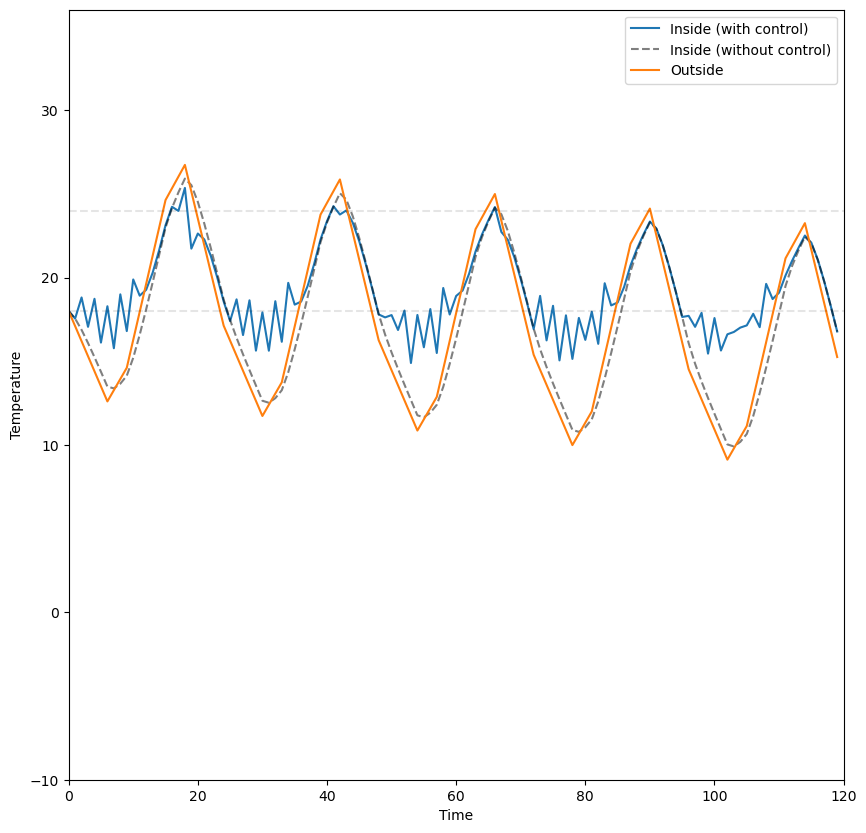

In [11]:
plt.figure(figsize=(10,10))
    
plt.plot(in_t, label="Inside (with control)")
plt.plot(in_t_noc, label="Inside (without control)", c="k", ls='--', alpha=0.5)
plt.plot(out_t, label="Outside")

plt.axhline(y=18, color='k', linestyle='--', alpha=0.1)
plt.axhline(y=24, color='k', linestyle='--', alpha=0.1)


plt.legend()

plt.xlabel("Time")
plt.ylabel("Temperature")
plt.xlim(0,24*5)
plt.ylim(-10,36)

### FITA

In [12]:
kb = MamdaniKnowledgeBase(rules, AggregationType.FITA)
RBController = FuzzyControlSystem(kb)

in_t = []
in_t.append(18)
in_t_noc = []
in_t_noc.append(18)
out_t = outside_temperature(18, 5)
ccnt = []
output_fuzzy_sets = {}

for t in range(1,24*5):
        cnt = RBController.evaluate({temperature_partition.name: in_t[t-1]})
        ccnt.append(cnt[controller_partition.name])
        in_t.append(inhouse_temperature(in_t[t-1], out_t[t], cnt[controller_partition.name]))
        in_t_noc.append(inhouse_temperature(in_t_noc[t-1], out_t[t], 0))

(-10.0, 36.0)

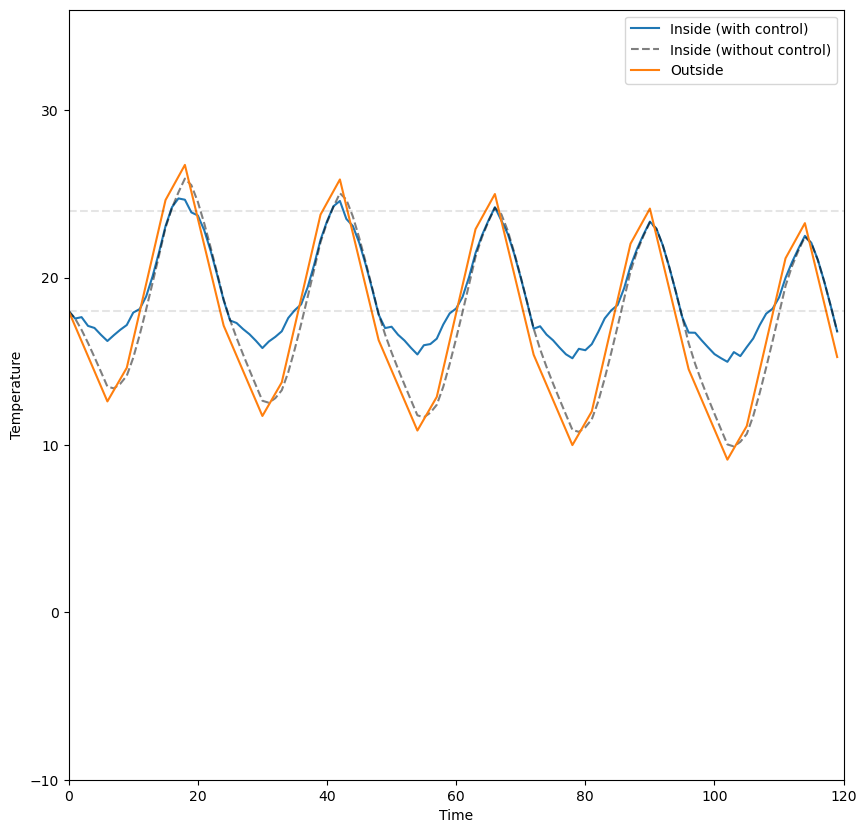

In [13]:
plt.figure(figsize=(10,10))
    
plt.plot(in_t, label="Inside (with control)")
plt.plot(in_t_noc, label="Inside (without control)", c="k", ls='--', alpha=0.5)
plt.plot(out_t, label="Outside")

plt.axhline(y=18, color='k', linestyle='--', alpha=0.1)
plt.axhline(y=24, color='k', linestyle='--', alpha=0.1)


plt.legend()

plt.xlabel("Time")
plt.ylabel("Temperature")
plt.xlim(0,24*5)
plt.ylim(-10,36)

## TSK Controller

In [14]:
rules = [
    TSKRule({temperature_partition.name: [temperature_partition['low']]},
            [18/(18-15), -1/(18-15)],
            controller_partition.name),
    TSKRule({temperature_partition.name: [temperature_partition['medium']]},
            [24/(24-18), -1/(24-18)],
            controller_partition.name),
    TSKRule({temperature_partition.name: [temperature_partition['high']]},
            [24/(27-24), -1/(27-24)],
            controller_partition.name),
]


In [15]:
kb = TSKKnowledgeBase(rules)
RBController = FuzzyControlSystem(kb)

in_t = []
in_t.append(18)
in_t_noc = []
in_t_noc.append(18)
out_t = outside_temperature(18, 5)
ccnt = []
output_fuzzy_sets = {}

for t in range(1,24*5):
        cnt = RBController.evaluate({temperature_partition.name: in_t[t-1]})
        ccnt.append(cnt[controller_partition.name])
        in_t.append(inhouse_temperature(in_t[t-1], out_t[t], cnt[controller_partition.name]))
        in_t_noc.append(inhouse_temperature(in_t_noc[t-1], out_t[t], 0))


(-10.0, 36.0)

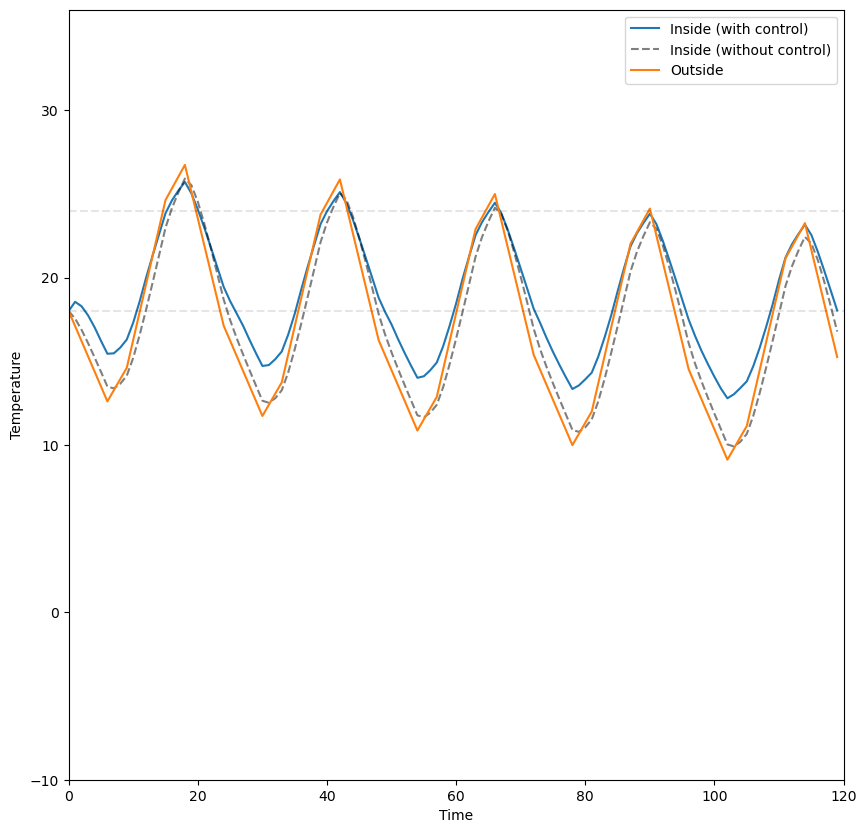

In [16]:
plt.figure(figsize=(10,10))
    
plt.plot(in_t, label="Inside (with control)")
plt.plot(in_t_noc, label="Inside (without control)", c="k", ls='--', alpha=0.5)
plt.plot(out_t, label="Outside")

plt.axhline(y=18, color='k', linestyle='--', alpha=0.1)
plt.axhline(y=24, color='k', linestyle='--', alpha=0.1)


plt.legend()

plt.xlabel("Time")
plt.ylabel("Temperature")
plt.xlim(0,24*5)
plt.ylim(-10,36)

## Singleton Controller

In [17]:
rules = [
    SingletonRule({temperature_partition.name: [temperature_partition['low']]},
                  controller_partition.name,
                  SingletonFuzzySet(2)),
    SingletonRule({temperature_partition.name: [temperature_partition['medium']]},
                  controller_partition.name,
                  SingletonFuzzySet(0)),
    SingletonRule({temperature_partition.name: [temperature_partition['high']]},
                  controller_partition.name,
                  SingletonFuzzySet(-2)),
]

In [18]:
kb = SingletonKnowledgeBase(rules)
RBController = FuzzyControlSystem(kb)

in_t = []
in_t.append(18)
in_t_noc = []
in_t_noc.append(18)
out_t = outside_temperature(18, 5)
ccnt = []
output_fuzzy_sets = {}

for t in range(1,24*5):
        cnt = RBController.evaluate({temperature_partition.name: in_t[t-1]})
        ccnt.append(cnt[controller_partition.name])
        in_t.append(inhouse_temperature(in_t[t-1], out_t[t], cnt[controller_partition.name]))
        in_t_noc.append(inhouse_temperature(in_t_noc[t-1], out_t[t], 0))



(-10.0, 36.0)

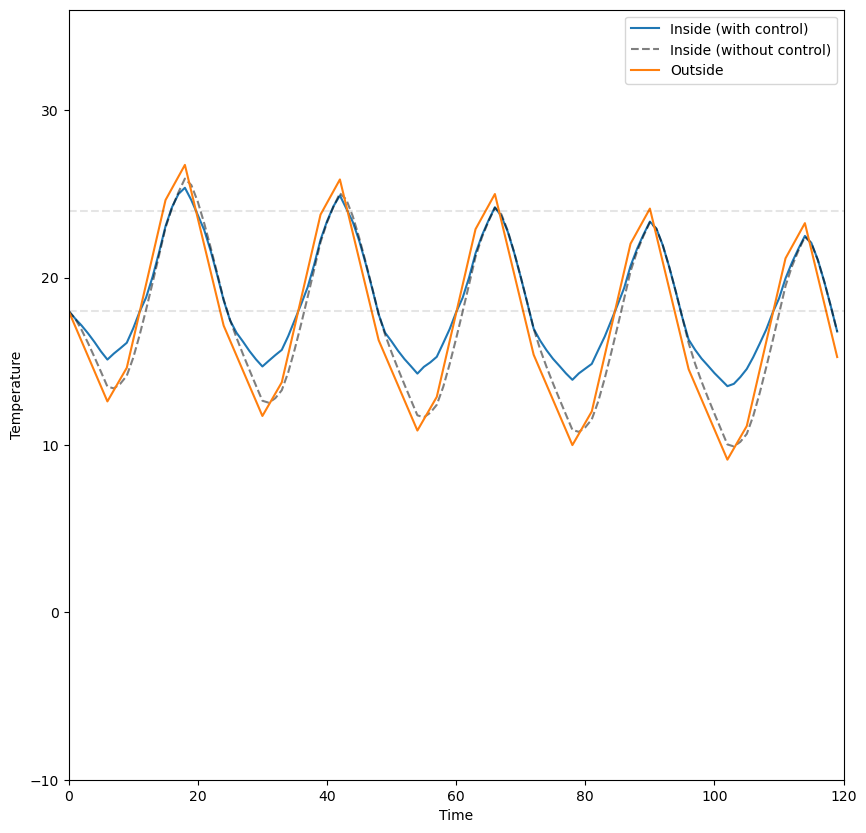

In [19]:
plt.figure(figsize=(10,10))
    
plt.plot(in_t, label="Inside (with control)")
plt.plot(in_t_noc, label="Inside (without control)", c="k", ls='--', alpha=0.5)
plt.plot(out_t, label="Outside")

plt.axhline(y=18, color='k', linestyle='--', alpha=0.1)
plt.axhline(y=24, color='k', linestyle='--', alpha=0.1)


plt.legend()

plt.xlabel("Time")
plt.ylabel("Temperature")
plt.xlim(0,24*5)
plt.ylim(-10,36)

## Classfier Controller

In [20]:
rules = [
    ClassifierRule({temperature_partition.name: [temperature_partition['low']]},
                   'target',
                   0),
    ClassifierRule({temperature_partition.name: [temperature_partition['medium']]},
                   'target',
                   1),
    ClassifierRule({temperature_partition.name: [temperature_partition['high']]},
                   'target',
                   2),
]

In [21]:
kb = ClassifierKnowledgeBase(rules)
RBController = FuzzyControlSystem(kb)

out_t = outside_temperature(18, 5)
ccnt = []

for t in out_t:
        cnt = RBController.evaluate({temperature_partition.name: t})
        ccnt.append(cnt['target'])
print(out_t)
print(ccnt)

[18, 17.1, 16.200000000000003, 15.300000000000002, 14.400000000000002, 13.500000000000002, 12.600000000000001, 13.270000000000001, 13.940000000000001, 14.610000000000001, 16.28, 17.950000000000003, 19.620000000000005, 21.290000000000006, 22.960000000000008, 24.63000000000001, 25.33000000000001, 26.03000000000001, 26.730000000000008, 25.130000000000006, 23.530000000000005, 21.930000000000003, 20.330000000000002, 18.73, 17.13, 16.23, 15.33, 14.43, 13.53, 12.629999999999999, 11.729999999999999, 12.399999999999999, 13.069999999999999, 13.739999999999998, 15.409999999999998, 17.08, 18.75, 20.42, 22.090000000000003, 23.760000000000005, 24.460000000000004, 25.160000000000004, 25.860000000000003, 24.26, 22.66, 21.06, 19.459999999999997, 17.859999999999996, 16.259999999999994, 15.359999999999994, 14.459999999999994, 13.559999999999993, 12.659999999999993, 11.759999999999993, 10.859999999999992, 11.529999999999992, 12.199999999999992, 12.869999999999992, 14.539999999999992, 16.209999999999994, 1

(-10.0, 36.0)

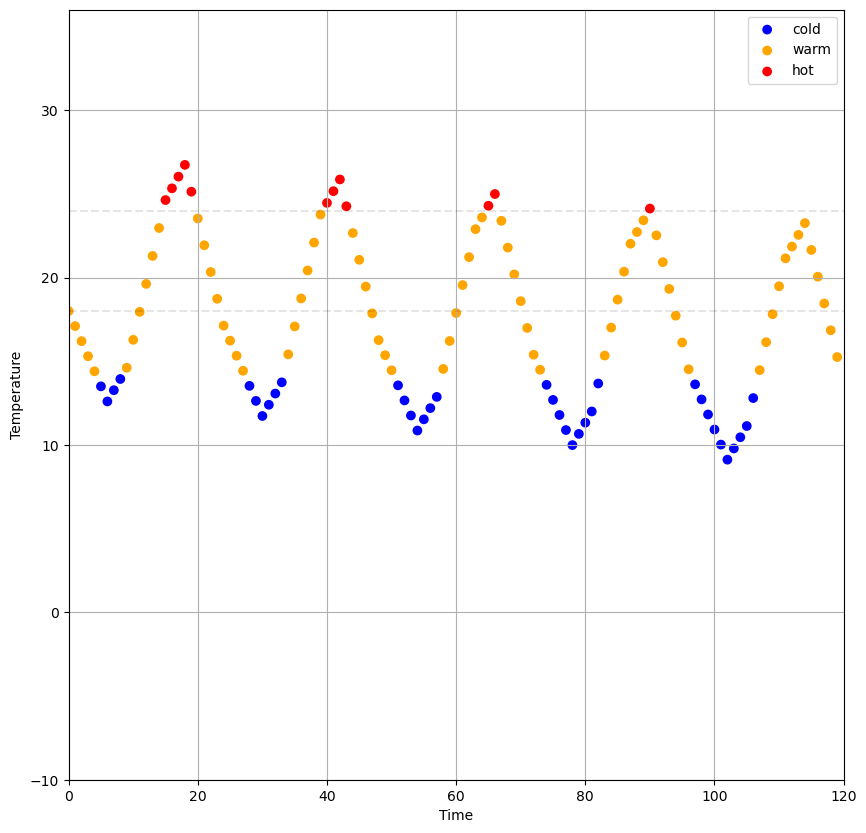

In [22]:
plt.figure(figsize=(10,10))

color = ['blue', 'orange', 'red']

y_low = []    
y_med = []    
y_high = []    
x_low = []    
x_med = []    
x_high = []    

for i in list(range(24*5)):
    if ccnt[i] == 0:
        y_low.append(out_t[i])
        x_low.append(i)
    elif ccnt[i] == 1:
        y_med.append(out_t[i])
        x_med.append(i)
    else:
        y_high.append(out_t[i])
        x_high.append(i)

plt.scatter(x_low, y_low, c=[color[0] for t in x_low], label='cold')
plt.scatter(x_med, y_med, c=[color[1] for t in x_med], label='warm')
plt.scatter(x_high, y_high, c=[color[2] for t in x_high], label='hot')

plt.axhline(y=18, color='k', linestyle='--', alpha=0.1)
plt.axhline(y=24, color='k', linestyle='--', alpha=0.1)


plt.legend()

plt.xlabel("Time")
plt.ylabel("Temperature")
plt.xlim(5,35)
plt.grid()
plt.xlim(0,24*5)
plt.ylim(-10,36)
